In [179]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os

In [246]:
from lib.geo import __c
from lib.sim_data_i3 import I3SimHandlerFtr
from lib.network import TriplePandleNet
from lib.plotting_tools import plot_event, adjust_plot_1d
from time_sampler import sample_times

In [410]:
key = jax.random.PRNGKey(2)

In [411]:
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

In [472]:
# Get a simulated muon event.

event_index = 5
meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

muon energy: 3.4 TeV
n_doms 43


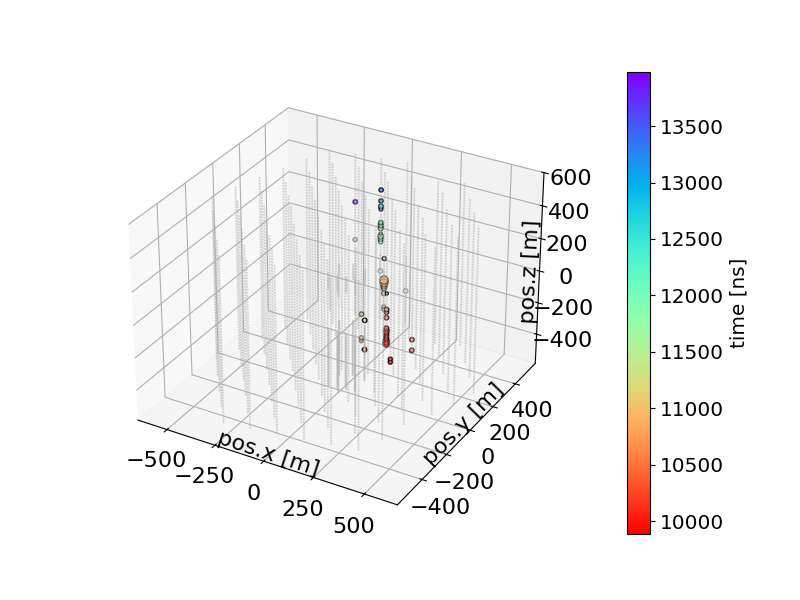

In [473]:
plot_event(event_data, geo=sim_handler.geo)

In [476]:
# Let's generate some new first hit times following our triple pandel model.
# (avoid problems with time smearing for now -> to be implemented: gaussian convoluted triple pandel.)

track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = jnp.float64(meta['muon_time'])
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

network = TriplePandleNet('./data/network/')

In [477]:
# Compute position of muon at the time of the highest charge dom hit.
# or use charge weighted mean of first hit

print("old track vertex:", track_pos)

from lib.geo import get_xyz_from_zenith_azimuth
#idx = np.argmax(event_data['charge'])
#centered_track_time = event_data.iloc[idx]['time']
centered_track_time = np.sum(event_data['charge'] * event_data['time']) / np.sum(event_data['charge'])
centered_track_pos = track_pos + (centered_track_time - track_time) * __c * get_xyz_from_zenith_azimuth(track_src)
print("new track vertex:", centered_track_pos)

centered_track_time = jnp.float64(centered_track_time)
centered_track_pos = jnp.array(centered_track_pos)

old track vertex: [ 143.40123598  106.94081331 -815.20509865]
new track vertex: [ -25.42355091  403.14288541 -154.63778486]


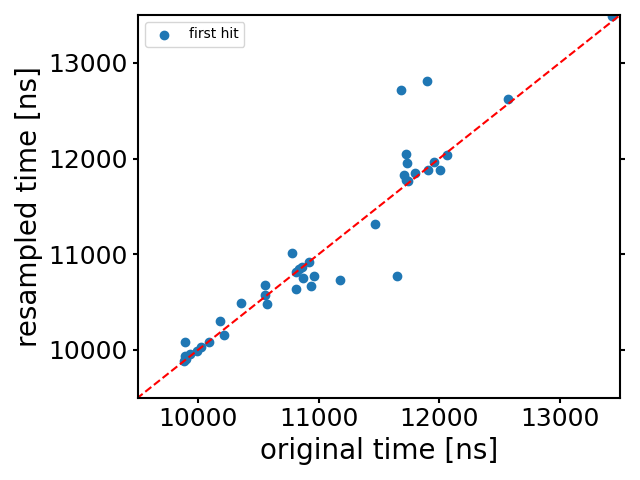

In [478]:
key, subkey = jax.random.split(key)
first_times = sample_times(event_data, track_pos, track_src, track_time, network, subkey)

# compare to original first hit times
fig, ax = plt.subplots()
ax.scatter(event_data['time'], first_times, label='first hit')
plt.plot([0, 100000], [0, 100000], "r--")

plot_args = {'xlim':[9500, 13500],
                 'ylim':[9500, 13500],
                 'xlabel':'original time [ns]',
                 'ylabel':'resampled time [ns]'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [479]:
# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fake_event_data = jnp.column_stack([jnp.array(event_data[['x', 'y', 'z']].to_numpy()), 
                                    jnp.array(first_times), 
                                    jnp.array(n_photons)])
print(fake_event_data.shape)

# Send to GPU.
fake_event_data.devices()
centered_track_pos.devices()
centered_track_time.devices()
track_src.devices()

(43, 5)


{cuda(id=0)}

In [480]:
from lib.geo import cherenkov_cylinder_coordinates_v
from lib.geo import rho_dom_relative_to_track_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs_v, transform_network_inputs_v
from typing import Any

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

@jax.jit
def neg_mpe_llh_direction_const_vertex(track_direction,
                                       track_vertex, 
                                       track_time,
                                       event_data,
                                       eps):
    """
    track_direction: (zenith, azimuth) in radians
    track_vertex: (x, y, z)
    track_time: t (this time defines the fit vertex)
    event_data: 2D array (n_doms X 5) where columns are x,y,z of dom location, and t for first hit time, and estimated number of photon hits from Qtot.
    """
    print(track_direction)
    
    dom_positions = event_data[:, :3]
    first_hit_times = event_data[:, 3]
    n_photons = event_data[:, 4]

    track_dir_xyz = get_xyz_from_zenith_azimuth(track_direction)
    
    geo_time, closest_approach_dist, closest_approach_z = \
    cherenkov_cylinder_coordinates_v(dom_positions,
                                     track_vertex,
                                     track_dir_xyz)

    closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, 
                                                       track_vertex, 
                                                       track_dir_xyz)

    track_zenith = track_direction[0]
    track_azimuth = track_direction[1]
    x = jnp.column_stack([closest_approach_dist,
                      closest_approach_rho,
                      closest_approach_z,
                      jnp.repeat(track_zenith, len(closest_approach_dist)),
                      jnp.repeat(track_azimuth, len(closest_approach_dist))])

    x_prime = transform_network_inputs_v(x)
    y_pred = network.eval_on_batch(x_prime)
    logits, av, bv = transform_network_outputs_v(y_pred)

    gm = tfd.MixtureSameFamily(
              mixture_distribution=tfd.Categorical(
                  logits=logits
                  ),
              components_distribution=tfd.Gamma(
                concentration=av,
                rate=bv,
                force_probs_to_zero_outside_support=True
                  )
            )

    delay_time = first_hit_times - (geo_time + track_time)
    llh = n_photons * gm.prob(delay_time) * (1-gm.cdf(delay_time))**(n_photons-1)
    llh = llh + eps
    return -2*jnp.sum(llh)

In [481]:
eps = jnp.float64(1.e-15)
llh = neg_mpe_llh_direction_const_vertex(track_src, 
                                         centered_track_pos, 
                                         centered_track_time, 
                                         fake_event_data, 
                                         eps)
print(llh)

Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=1/0)>
-5.683196606387899


In [482]:
neg_mpe_llh_direction_const_vertex_v = jax.jit(jax.vmap(neg_mpe_llh_direction_const_vertex, (0, None, None, None, None), 0))

[2.66512738 5.23043102]


/home/storage/hans/jax_reco/lib/plotting_tools.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


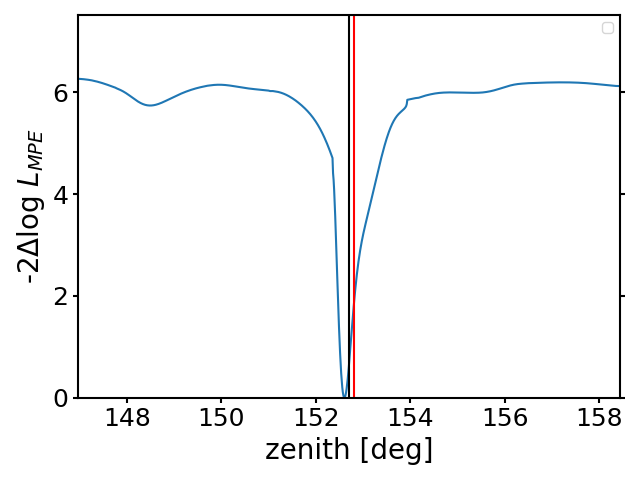

In [483]:
print(track_src)
n_eval = 1000
zenith = np.linspace(track_src[0]-0.1, track_src[0]+0.1, n_eval)
azimuth = np.repeat(track_src[1], n_eval)
init_dirs = np.column_stack([zenith, azimuth])
init_dirs = jnp.array(init_dirs)
logls = neg_mpe_llh_direction_const_vertex_v(init_dirs, 
                                     centered_track_pos, 
                                     centered_track_time, 
                                     fake_event_data, 
                                     eps)
delta_logl = logls-np.amin(logls)

fig, ax = plt.subplots()
plt.plot(np.rad2deg(zenith), logls-np.amin(logls))
ax.axvline(np.rad2deg(track_src[0]), color='k')
ax.axvline(np.rad2deg(meta['spline_mpe_zenith']), color='r')

plot_args = {'xlim':[np.rad2deg(zenith[0]), np.rad2deg(zenith[-1])],
             'ylim':[0.0, 1.2*np.amax(delta_logl)],
             'xlabel':'zenith [deg]',
             'ylabel':'-2$\\Delta$log $L_{MPE}$'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

[2.66512738 5.23043102]


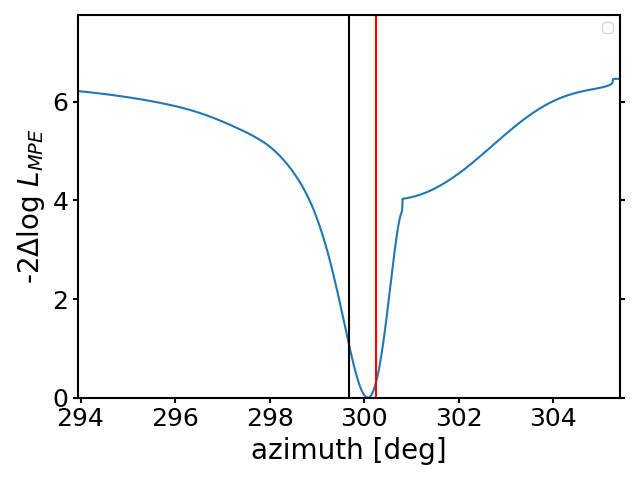

In [484]:
print(track_src)
n_eval = 1000
azimuth = np.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
zenith = np.repeat(track_src[0], n_eval)
init_dirs = np.column_stack([zenith, azimuth])
init_dirs = jnp.array(init_dirs)

logls = neg_mpe_llh_direction_const_vertex_v(init_dirs, 
                                     centered_track_pos, 
                                     centered_track_time, 
                                     fake_event_data, 
                                     eps)

delta_logl = logls-np.amin(logls)
fig, ax = plt.subplots()
plt.plot(np.rad2deg(azimuth), delta_logl)
ax.axvline(np.rad2deg(track_src[1]), color='k')
ax.axvline(np.rad2deg(meta['spline_mpe_azimuth']), color='r')

plot_args = {'xlim':[np.rad2deg(azimuth[0]), np.rad2deg(azimuth[-1])],
             'ylim':[0.0, 1.2*np.amax(delta_logl)],
             'xlabel':'azimuth [deg]',
             'ylabel':'-2$\\Delta$log $L_{MPE}$'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

(200, 200)


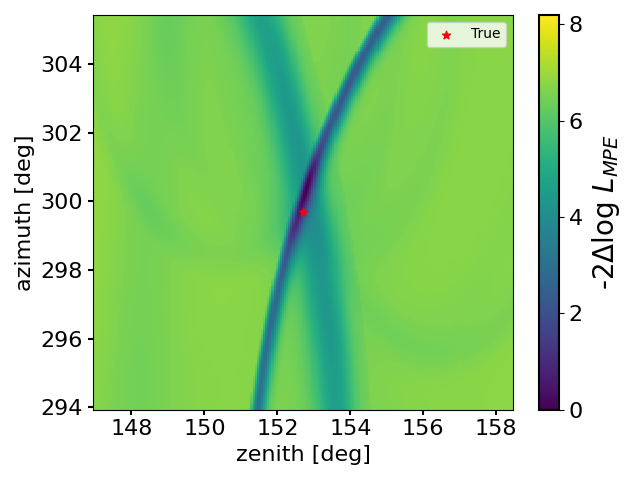

In [485]:
n_eval = 200

zenith = np.linspace(track_src[0]-0.1, track_src[0]+0.1, n_eval)
azimuth = np.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
X, Y = np.meshgrid(zenith, azimuth)
print(X.shape)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = neg_mpe_llh_direction_const_vertex_v(init_dirs, 
                                     centered_track_pos, 
                                     centered_track_time, 
                                     fake_event_data, 
                                     eps)
logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([1.2*np.amax(delta_logl)]), shading='auto')
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="True")
#ax.scatter(np.rad2deg(meta['spline_mpe_zenith']), np.rad2deg(meta['spline_mpe_azimuth']), marker="x", color='cyan', label="SplineMPE")
plt.legend()
plt.tight_layout()
plt.show()

In [463]:
#%timeit logls = neg_mpe_llh_direction_const_vertex_v(init_dirs, centered_track_pos, centered_track_time, fake_event_data, eps)

In [437]:
#import jaxopt
#init_dir = jnp.array([meta['spline_mpe_zenith'], meta['spline_mpe_azimuth']])
#print(init_dir)
#print(neg_mpe_llh_direction_const_vertex(init_dir, 
#                                         centered_track_pos, 
#                                         centered_track_time, 
#                                         fake_event_data, eps))

In [ ]:
#solver_1 = jaxopt.ScipyMinimize(method = "l-bfgs-b", fun=neg_mpe_llh_direction_const_vertex, tol = 1e-12, maxiter=5000)
#solver_1_sol = solver_1.run(init_dir, centered_track_pos, centered_track_time, fake_event_data, eps)
#print(solver_1_sol.params)

In [202]:
#print(solver_1_sol)

In [153]:
'''
solver_2 = jaxopt.LBFGS(fun=neg_mpe_llh_direction_const_vertex, 
                        maxiter=5000, 
                        max_stepsize=1.e-4)

solver_2_sol = solver_2.run(init_dir, 
                            centered_track_pos, 
                            centered_track_time, 
                            fake_event_data,
                            eps)

print(solver_2_sol.params)
'''

'\nsolver_2 = jaxopt.LBFGS(fun=neg_mpe_llh_direction_const_vertex, \n                        maxiter=5000, \n                        max_stepsize=1.e-4)\n\nsolver_2_sol = solver_2.run(init_dir, \n                            centered_track_pos, \n                            centered_track_time, \n                            fake_event_data,\n                            eps)\n\nprint(solver_2_sol.params)\n'